In [1]:
%matplotlib inline

In [2]:
from __future__ import division

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
import scipy as sp
import seaborn as sns
from theano import tensor as tt
import pandas as pd

In [4]:
blue, *_ = sns.color_palette()



In [5]:
SEED = 5132290 # from random.org

np.random.seed(SEED)

In [6]:
old_faithful_df = pd.read_csv(pm.get_data('old_faithful.csv'))



In [7]:
old_faithful_df['std_waiting'] = (old_faithful_df.waiting - old_faithful_df.waiting.mean()) / old_faithful_df.waiting.std()

In [8]:
N = old_faithful_df.shape[0]

K = 30

In [9]:
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])

    return beta * portion_remaining

In [10]:
with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))

    tau = pm.Gamma('tau', 1., 1., shape=K)
    lambda_ = pm.Uniform('lambda', 0, 5, shape=K)
    mu = pm.Normal('mu', 0, tau=lambda_ * tau, shape=K)
    obs = pm.NormalMixture('obs', w, mu, tau=lambda_ * tau,
                           observed=old_faithful_df.std_waiting.values)

In [11]:
with model:
    mean_field = pm.fit(method='advi')

Average Loss = 425.36: 100%|██████████| 10000/10000 [00:08<00:00, 1156.87it/s]
Finished [100%]: Average Loss = 425.24


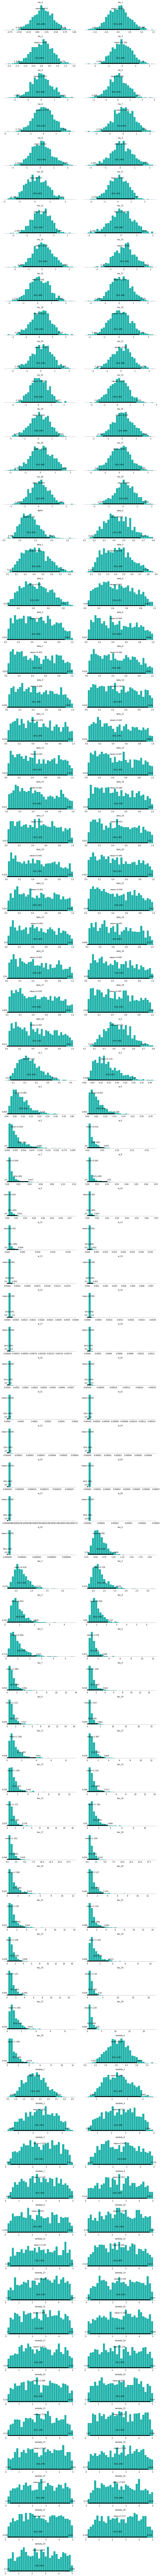

In [12]:
pm.plot_posterior(mean_field.sample(1000), color='LightSeaGreen');

In [13]:
help(pm.callbacks.CheckParametersConvergence)

Help on class CheckParametersConvergence in module pymc3.variational.callbacks:

class CheckParametersConvergence(Callback)
 |  Convergence stopping check
 |  
 |  Parameters
 |  ----------
 |  every : int
 |      check frequency
 |  tolerance : float
 |      if diff norm < tolerance : break
 |  diff : str
 |      difference type one of {'absolute', 'relative'}
 |  ord : {non-zero int, inf, -inf, 'fro', 'nuc'}, optional
 |      see more info in :func:`numpy.linalg.norm`
 |  
 |  Examples
 |  --------
 |  >>> with model:
 |  ...     approx = pm.fit(
 |  ...         n=10000, callbacks=[
 |  ...             CheckParametersConvergence(
 |  ...                 every=50, diff='absolute',
 |  ...                 tolerance=1e-4)
 |  ...         ]
 |  ...     )
 |  
 |  Method resolution order:
 |      CheckParametersConvergence
 |      Callback
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __call__(self, approx, _, i)
 |      Call self as a function.
 |  
 |  __init__(self, e

In [14]:

from pymc3.variational.callbacks import CheckParametersConvergence

with model:
    mean_field = pm.fit(method='advi', callbacks=[CheckParametersConvergence()])



Average Loss = 425.02: 100%|██████████| 10000/10000 [00:12<00:00, 789.26it/s]
Finished [100%]: Average Loss = 425.16


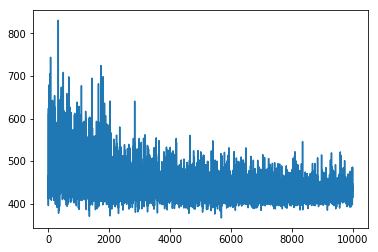

In [15]:
plt.plot(mean_field.hist);


In [16]:
with model:
    mean_field = pm.fit(method='advi', callbacks=[pm.callbacks.CheckParametersConvergence(diff='absolute')])

Average Loss = 425.23: 100%|██████████| 10000/10000 [00:11<00:00, 851.29it/s]
Finished [100%]: Average Loss = 425.22


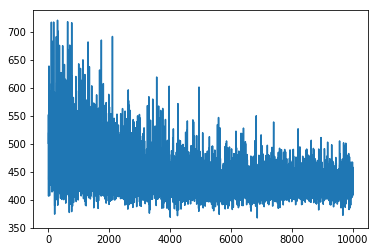

In [17]:

plt.plot(mean_field.hist);



In [ ]:
with model:
    advi = pm.ADVI()

In [ ]:
advi.approx

In [ ]:

advi.approx.shared_params



{'mu': mu, 'rho': rho}

In [ ]:
advi.approx.mean.eval(), advi.approx.std.eval()

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),
 array([0.69314718, 0.69314718, 0.69314718, 0.69314718, 0.69314718,
        0.69314718, 0.69314718, 0.69314718, 0.69314718, 0.69314718,
        0.69314718, 0.69314718, 0.69314718, 0.69314718, 0.69314718,
        0.69314718, 0.69314718, 0.69314718, 0.69314718, 0.69314718,
        0.69314718, 0.69314718, 0.69314718, 0.69314718, 0.69314718,
        0.69314718, 0.69314718, 0.69314718, 0.69314718, 0.69314718,
        0.69314718, 0.69314718, 0.69314718

In [ ]:
tracker = pm.callbacks.Tracker(
    mean=advi.approx.mean.eval,  # callable that returns mean
    std=advi.approx.std.eval  # callable that returns std
)


In [ ]:
approx = advi.fit(20000, callbacks=[tracker])

Average Loss = inf: 100%|██████████| 20000/20000 [00:24<00:00, 831.48it/s]   
Finished [100%]: Average Loss = 409.7


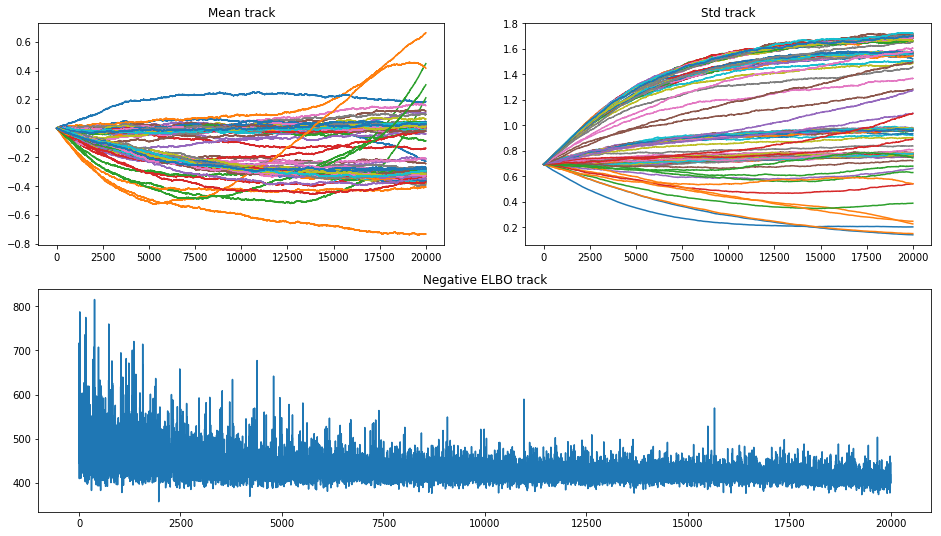

In [ ]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker['mean'])
mu_ax.set_title('Mean track')
std_ax.plot(tracker['std'])
std_ax.set_title('Std track')
hist_ax.plot(advi.hist)
hist_ax.set_title('Negative ELBO track');

In [ ]:

advi.refine(100000)



Average Loss = 363.74: 100%|██████████| 100000/100000 [01:43<00:00, 965.90it/s]
Finished [100%]: Average Loss = 363.72


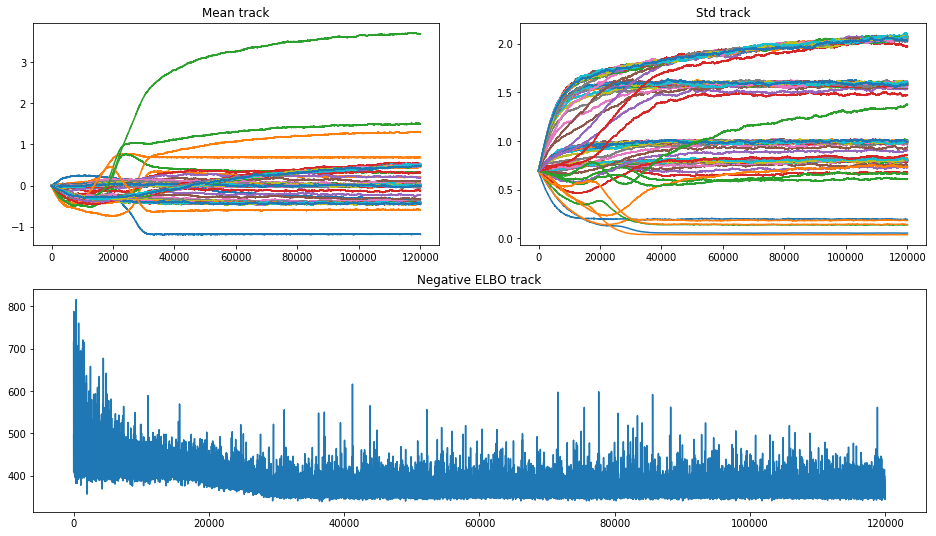

In [ ]:

fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker['mean'])
mu_ax.set_title('Mean track')
std_ax.plot(tracker['std'])
std_ax.set_title('Std track')
hist_ax.plot(advi.hist)
hist_ax.set_title('Negative ELBO track');



In [ ]:
with model:
    trace = pm.sample(50000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, lambda, tau, beta, alpha]
Sampling 4 chains:  98%|█████████▊| 197561/202000 [1:10:00<03:07, 23.71draws/s]   